# Data Analytics Project - Models

# Pair 2 - BEML LSTM

---

# 1. Import required modules

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


---

# 2. Get Pair 2 Orders Dataset

## 2.1. Get the orders

In [2]:
orders_df = pd.read_csv('../../Preprocess/Pair2/Pair2_orders.csv')
orders_df.head()

,Date,BEML_Close,ESCORTS_Close,Spread,zscore,Orders
0,2018-08-06,909.099976,880.049988,29.049988,1.821236,SHORT
1,2018-08-07,868.599976,873.700012,-5.100037,0.672698,FLAT
2,2018-08-08,825.150024,876.500000,-51.349976,-0.882785,GET_OUT_OF_POSITION
3,2018-08-09,810.150024,878.750000,-68.599976,-1.462939,FLAT
4,2018-08-10,807.750000,865.250000,-57.500000,-1.089624,FLAT


In [3]:
orders_df.tail()

,Date,BEML_Close,ESCORTS_Close,Spread,zscore,Orders
54,2018-10-29,561.150024,591.450012,-30.299988,-0.174830,FLAT
55,2018-10-30,585.650024,603.950012,-18.299988,0.228756,FLAT
56,2018-10-31,587.250000,627.000000,-39.750000,-0.492654,FLAT
57,2018-11-01,632.400024,674.450012,-42.049988,-0.570007,FLAT
58,2018-11-02,688.900024,676.000000,12.900024,1.278078,FLAT


## 2.2. Visualize the orders

Text(0, 0.5, 'zscore')

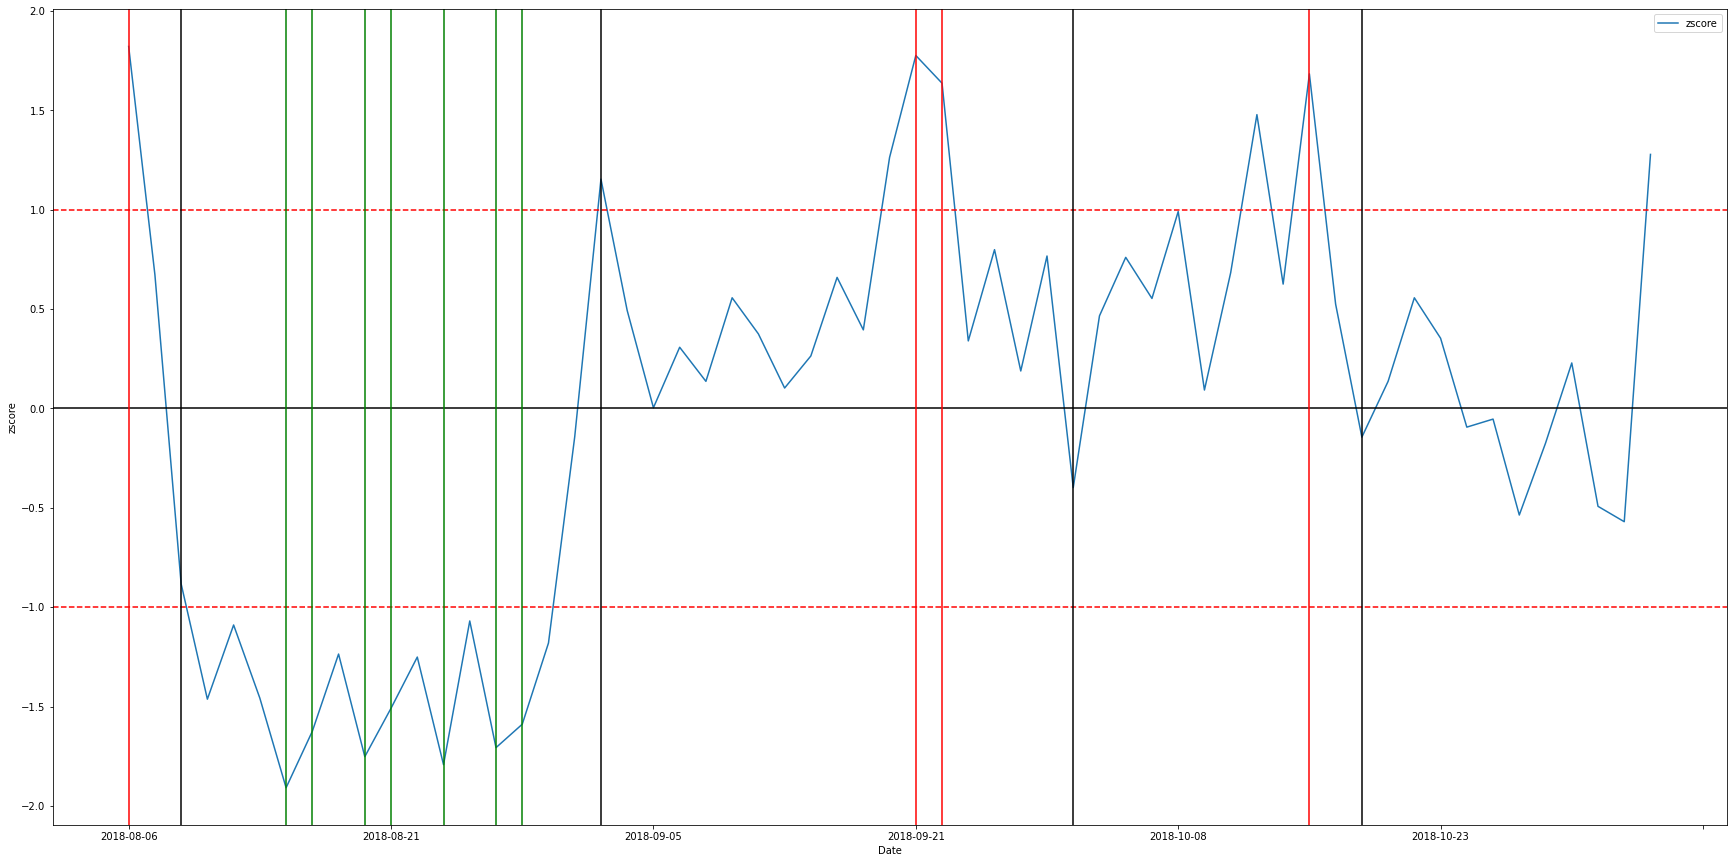

In [4]:
# Plotting the zscore of the Spread
orders_plt = orders_df.plot(x='Date', y='zscore', figsize=(30,15))

# Plotting the lines at mean, 1 and 2 std. dev.
orders_plt.axhline(0, c='black')
orders_plt.axhline(1, c='red', ls = "--")
orders_plt.axhline(-1, c='red', ls = "--")

# Extracting orders
Orders = orders_df['Orders']

# Plot vertical lines where orders are placed
for order in range(len(Orders)):
    
    if Orders[order] != "FLAT":
        
        # GREEN line for a long position
        if Orders[order] == "LONG":
            orders_plt.axvline(x=order, c = "green")
        
        # RED line for a short position
        elif Orders[order] == "SHORT":
            orders_plt.axvline(x=order, c = "red")
        
        # BLACK line for getting out of all positions at that point
        else:
            orders_plt.axvline(x=order, c = "black")

orders_plt.set_ylabel("zscore")

__In the figure above:__
- __Blue line__ - zscore of the Spread
- __Black horizontal line__ at 0 - Mean
- __Red dotted horizontal lines__ - at +1 and -1 standard deviations
- __Green vertical line__ - represents long position taken on that day
- __Red vertical line__ - represents short position taken on that day
- __Black vertical line__ - represents getting out of all open positions till that point


## 2.3 Visualize the close prices of both stocks

Text(0, 0.5, 'Price')

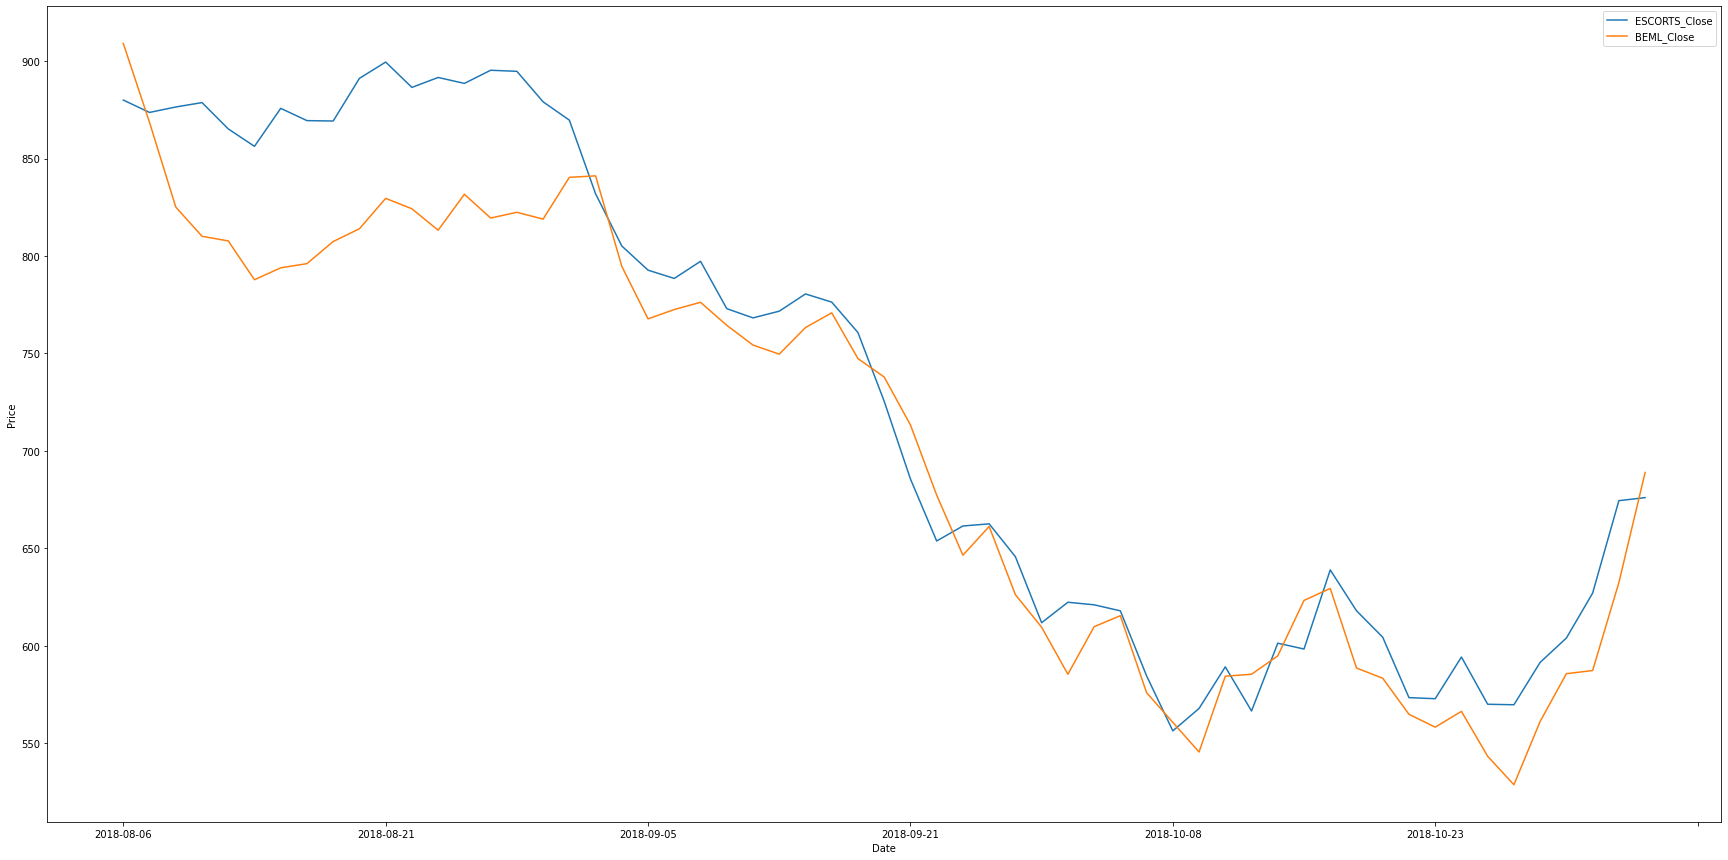

In [5]:
orders_df_plt = orders_df.plot(x='Date', y=['ESCORTS_Close', 'BEML_Close'], figsize=(30,15))
orders_df_plt.set_xlabel("Date")
orders_df_plt.set_ylabel("Price")

---

# 3. BEML Linear Regression Model

## 3.1. Get the Complete BEML dataset

In [6]:
beml_df = pd.read_csv("../../Storage/Companies_with_names_exchange/BEMLNSE.csv")
beml_df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Company,Exchange
0,2017-01-02,1006.500000,989.150024,1004.000000,996.299988,150354.0,968.879944,BEML,NSE
1,2017-01-03,1015.950012,996.200012,1002.799988,1009.299988,285489.0,981.522095,BEML,NSE
2,2017-01-04,1023.000000,1002.750000,1013.799988,1005.799988,202005.0,978.118469,BEML,NSE
3,2017-01-05,1017.500000,993.599976,1006.400024,1001.599976,150463.0,974.033997,BEML,NSE
4,2017-01-06,1009.000000,987.900024,998.500000,993.549988,161214.0,966.205627,BEML,NSE


- We can see that we have data from 2017-01-02

## 3.2. Get BEML training data

### 3.2.1 Get complete beml dataset

In [7]:
beml_df = beml_df.drop(columns=['High', 'Low', 'Open', 'Volume', 'Adj Close', 'Company', 'Exchange'])
beml_df.head()

,Date,Close
0,2017-01-02,996.299988
1,2017-01-03,1009.299988
2,2017-01-04,1005.799988
3,2017-01-05,1001.599976
4,2017-01-06,993.549988


- We can see that the period where the stocks are correlated and co-integration starts from 2018-09-04.
- Thus the test data for which we need to make predictions is from 2018-09-04 to when the period ends at 2018-12-03.
- We take 1 year's worth of training data for our model, which means that the time period of our training data is from 2017-09-03 to 2018-09-04.


### 3.2.2. Crop dataset within training range

In [8]:
beml_df_train = beml_df[beml_df['Date'] >= '2017-09-03']
beml_df_train.head()

,Date,Close
166,2017-09-04,1855.599976
167,2017-09-05,1851.000000
168,2017-09-06,1836.150024
169,2017-09-07,1882.949951
170,2017-09-08,1855.949951


In [9]:
beml_df_train = beml_df_train[beml_df_train['Date'] <= '2018-09-04']
beml_df_train.tail()

,Date,Close
412,2018-08-29,822.450012
413,2018-08-30,818.950012
414,2018-08-31,840.400024
415,2018-09-03,841.150024
416,2018-09-04,794.700012


### 3.2.3 Get the training data

In [10]:
beml_train = beml_df_train.copy()

In [11]:
beml_train = beml_train.reset_index(drop=True)
beml_train = beml_train.copy()
beml_train.head()

,Date,Close
0,2017-09-04,1855.599976
1,2017-09-05,1851.000000
2,2017-09-06,1836.150024
3,2017-09-07,1882.949951
4,2017-09-08,1855.949951


In [12]:
beml_train_plot_copy = beml_train.copy()
beml_train.tail()

,Date,Close
246,2018-08-29,822.450012
247,2018-08-30,818.950012
248,2018-08-31,840.400024
249,2018-09-03,841.150024
250,2018-09-04,794.700012


In [13]:
beml_train = beml_train.drop(columns=['Date'])
beml_train = beml_train.values
beml_train

array([[1855.59997559],
       [1851.        ],
       [1836.15002441],
       [1882.94995117],
       [1855.94995117],
       [1867.55004883],
       [1884.84997559],
       [1845.5       ],
       [1866.84997559],
       [1847.5       ],
       [1852.59997559],
       [1934.09997559],
       [1871.40002441],
       [1826.40002441],
       [1723.25      ],
       [1673.94995117],
       [1686.25      ],
       [1643.55004883],
       [1643.40002441],
       [1585.94995117],
       [1599.80004883],
       [1668.69995117],
       [1729.19995117],
       [1739.90002441],
       [1704.59997559],
       [1729.84997559],
       [1699.09997559],
       [1719.84997559],
       [1721.30004883],
       [1727.84997559],
       [1778.94995117],
       [1731.75      ],
       [1691.        ],
       [1723.59997559],
       [1738.25      ],
       [1746.25      ],
       [1701.09997559],
       [1701.40002441],
       [1702.5       ],
       [1713.59997559],
       [1720.40002441],
       [1719.550

In [14]:
len(beml_train)

251

## 3.3. Get BEML Test Data

In [15]:
beml_test = beml_df[(beml_df['Date'] >= '2018-09-04') & (beml_df['Date'] <= '2018-12-03')].copy()
beml_test.head()

,Date,Close
416,2018-09-04,794.700012
417,2018-09-05,767.750000
418,2018-09-06,772.549988
419,2018-09-07,776.250000
420,2018-09-10,764.450012


In [16]:
beml_test.tail()

,Date,Close
470,2018-11-27,758.849976
471,2018-11-28,775.200012
472,2018-11-29,764.950012
473,2018-11-30,752.849976
474,2018-12-03,747.599976


In [17]:
beml_test.reset_index(drop=True, inplace=True)
beml_test.index += 251
beml_test.head()

,Date,Close
251,2018-09-04,794.700012
252,2018-09-05,767.750000
253,2018-09-06,772.549988
254,2018-09-07,776.250000
255,2018-09-10,764.450012


In [18]:
beml_test_plot_copy = beml_test.copy()
beml_test = beml_test.drop(columns=['Date'])
beml_test = beml_test.values
beml_test

array([[794.70001221],
       [767.75      ],
       [772.54998779],
       [776.25      ],
       [764.45001221],
       [754.29998779],
       [749.65002441],
       [763.29998779],
       [770.84997559],
       [747.34997559],
       [737.90002441],
       [713.29998779],
       [677.29998779],
       [646.45001221],
       [661.20001221],
       [626.20001221],
       [609.5       ],
       [585.34997559],
       [609.75      ],
       [615.40002441],
       [575.90002441],
       [560.65002441],
       [545.45001221],
       [584.34997559],
       [585.34997559],
       [594.79998779],
       [623.25      ],
       [629.40002441],
       [588.54998779],
       [583.29998779],
       [564.79998779],
       [558.20001221],
       [566.29998779],
       [543.25      ],
       [528.65002441],
       [561.15002441],
       [585.65002441],
       [587.25      ],
       [632.40002441],
       [688.90002441],
       [708.25      ],
       [714.40002441],
       [713.29998779],
       [729

In [19]:
len(beml_test)

59

## 3.4 Create and Train BEML Model

In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(beml_train)
scaled_train_data

array([[9.33387073e-01],
       [9.29483662e-01],
       [9.16882383e-01],
       [9.56595506e-01],
       [9.33684053e-01],
       [9.43527575e-01],
       [9.58207814e-01],
       [9.24816514e-01],
       [9.42933512e-01],
       [9.26513658e-01],
       [9.30841357e-01],
       [1.00000000e+00],
       [9.46794557e-01],
       [9.08608803e-01],
       [8.21078549e-01],
       [7.79243892e-01],
       [7.89681373e-01],
       [7.53447377e-01],
       [7.53320070e-01],
       [7.04569529e-01],
       [7.16322338e-01],
       [7.74788888e-01],
       [8.26127512e-01],
       [8.35207298e-01],
       [8.05252654e-01],
       [8.26679105e-01],
       [8.00585507e-01],
       [8.18193382e-01],
       [8.19423874e-01],
       [8.24981961e-01],
       [8.68343985e-01],
       [8.28291413e-01],
       [7.93712092e-01],
       [8.21375528e-01],
       [8.33807133e-01],
       [8.40595712e-01],
       [8.02282651e-01],
       [8.02537264e-01],
       [8.03470673e-01],
       [8.12889805e-01],


In [21]:
X_train, y_train = [], []
for i in range(10,len(beml_train)):
    X_train.append(scaled_train_data[i-10:i,0])
    y_train.append(scaled_train_data[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [22]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

In [23]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=2)

Epoch 1/1
 - 2s - loss: 0.0136


## 3.5. Get predictions

In [24]:
scaled_test_data = beml_test.reshape(-1,1)
scaled_test_data = scaler.transform(scaled_test_data)
scaled_test_data.shape

(59, 1)

In [25]:
X_test = []
for i in range(10, scaled_test_data.shape[0]):
    X_test.append(scaled_test_data[i-10:i,0])
X_test = np.array(X_test)
X_test

array([[ 0.03313674,  0.0102677 ,  0.01434084,  0.01748057,  0.00746743,
        -0.0011456 , -0.00509143,  0.00649155,  0.01289826, -0.00704319],
       [ 0.0102677 ,  0.01434084,  0.01748057,  0.00746743, -0.0011456 ,
        -0.00509143,  0.00649155,  0.01289826, -0.00704319, -0.01506216],
       [ 0.01434084,  0.01748057,  0.00746743, -0.0011456 , -0.00509143,
         0.00649155,  0.01289826, -0.00704319, -0.01506216, -0.03593707],
       [ 0.01748057,  0.00746743, -0.0011456 , -0.00509143,  0.00649155,
         0.01289826, -0.00704319, -0.01506216, -0.03593707, -0.06648567],
       [ 0.00746743, -0.0011456 , -0.00509143,  0.00649155,  0.01289826,
        -0.00704319, -0.01506216, -0.03593707, -0.06648567, -0.09266411],
       [-0.0011456 , -0.00509143,  0.00649155,  0.01289826, -0.00704319,
        -0.01506216, -0.03593707, -0.06648567, -0.09266411, -0.08014767],
       [-0.00509143,  0.00649155,  0.01289826, -0.00704319, -0.01506216,
        -0.03593707, -0.06648567, -0.09266411

In [26]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)
len(closing_price)

49

In [27]:
print('Mean Absolute Error:', metrics.mean_absolute_error(beml_test[10:], closing_price))
print('Mean Squared Error:', metrics.mean_squared_error(beml_test[10:], closing_price))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(beml_test[10:], closing_price)))

Mean Absolute Error: 51.439661142777425
Mean Squared Error: 3593.035232163282
Root Mean Squared Error: 59.941932169085796


## 3.6. Visualize the predicitons vs test data

In [28]:
closing_price_df = pd.DataFrame(closing_price, columns=['price'])
closing_price_df.index += 260
closing_price = closing_price_df['price']
closing_price

260    745.866516
261    741.995911
262    738.635986
263    732.583435
264    723.583679
265    714.267578
266    703.754700
267    691.871216
268    677.403625
269    662.731995
270    650.539734
271    638.508301
272    627.461792
273    617.897034
274    611.192749
275    604.434998
276    601.073608
277    600.600647
278    603.130127
279    603.613342
280    603.206909
281    604.126770
282    604.687073
283    605.425720
284    602.358521
285    597.962219
286    593.389587
287    588.526428
288    584.751404
289    586.256470
290    591.960205
291    602.174316
292    615.094543
293    628.712708
294    644.784607
295    661.568665
296    675.662231
297    686.892822
298    697.414673
299    703.337830
300    705.578064
301    707.793701
302    710.323303
303    713.442139
304    716.342651
305    720.156921
306    724.519165
307    729.774170
308    733.247681
Name: price, dtype: float32

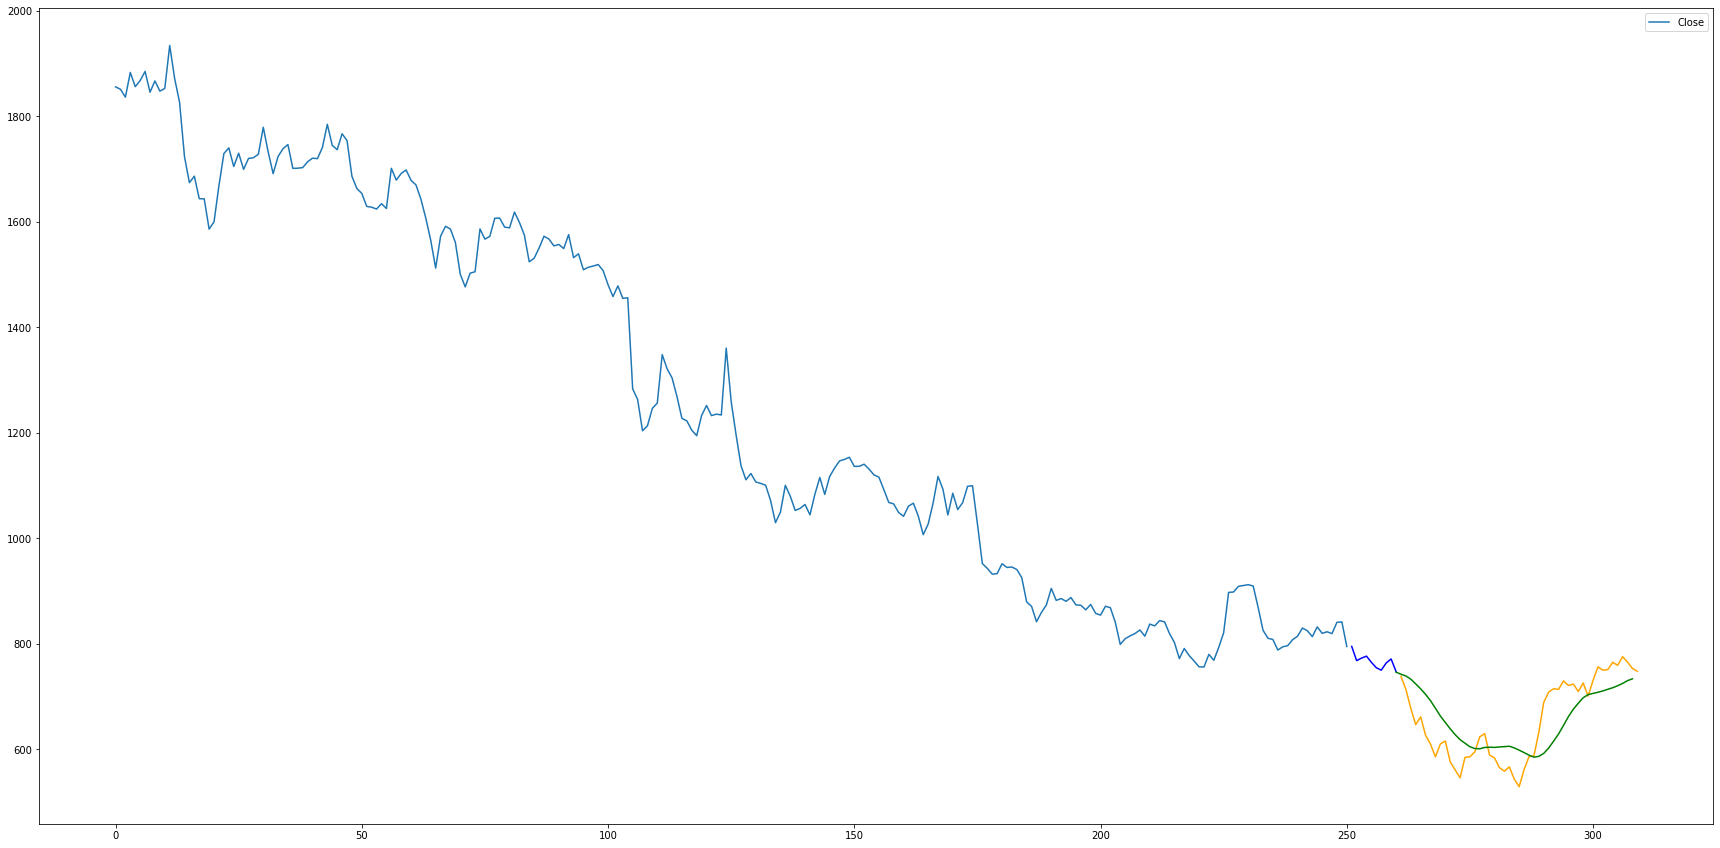

In [29]:
beml_model_plt = beml_train_plot_copy.plot(y=['Close'], figsize=(30,15))
beml_model_plt.plot(beml_test_plot_copy["Close"][:10], c='blue')
beml_model_plt.plot(beml_test_plot_copy["Close"][10:], c='orange')
beml_model_plt.plot(closing_price, c='green')

__In the graph above:__
- We can see the training data in blue
- The test data in orange
- The predictions made by the models in green

# 4. Put the results in a file

In [30]:
beml_predictions_df = pd.read_csv('Beml_predicitions.csv')
beml_predictions_df.head()

,Date,Actual_Close,Linear_regression_Close,ARIMA_Close
0,2018-08-06,909.099976,762.413834,793.382360
1,2018-08-07,868.599976,755.794835,786.817999
2,2018-08-08,825.150024,749.175836,801.045660
3,2018-08-09,810.150024,742.556836,793.949767
4,2018-08-10,807.750000,747.687468,784.870888


In [31]:
beml_predictions_df.tail()

,Date,Actual_Close,Linear_regression_Close,ARIMA_Close
54,2018-10-29,561.150024,533.549771,721.720305
55,2018-10-30,585.650024,526.930772,722.667374
56,2018-10-31,587.250000,520.311773,718.083306
57,2018-11-01,632.400024,553.395742,726.380481
58,2018-11-02,688.900024,504.665958,733.986128


In [32]:
closing_price_df.index -= 250
closing_price_df

,price
10,745.866516
11,741.995911
12,738.635986
13,732.583435
14,723.583679
15,714.267578
16,703.754700
17,691.871216
18,677.403625
19,662.731995


In [33]:
beml_predictions_df['LSTM_Close'] = closing_price_df['price']
beml_predictions_df

,Date,Actual_Close,Linear_regression_Close,ARIMA_Close,LSTM_Close
0,2018-08-06,909.099976,762.413834,793.382360,NaN
1,2018-08-07,868.599976,755.794835,786.817999,NaN
2,2018-08-08,825.150024,749.175836,801.045660,NaN
3,2018-08-09,810.150024,742.556836,793.949767,NaN
4,2018-08-10,807.750000,747.687468,784.870888,NaN
5,2018-08-13,787.849976,741.068469,780.706759,NaN
6,2018-08-14,793.950012,734.449470,766.809046,NaN
7,2018-08-16,796.099976,721.211471,774.102287,NaN
8,2018-08-17,807.450012,726.342103,767.933075,NaN
9,2018-08-20,814.000000,719.723104,782.385302,NaN


In [34]:
beml_predictions_df.to_csv('Beml_predicitions.csv', index=False)